# 第7讲：视觉里程计1


## 7.1 特征点法

视觉SLAM分为视觉前端和优化后端。前端也称为视觉里程计（VO），根据相邻图像信息，粗略估计相机运动，为后端提供初始值。

VO的实现按是否需要提取特征，分为特征点法前端及不提特征的直接法前端。基于特征点法的前端运行稳定，对光照、动态物体不敏感，是比较成熟的解决方。

### 7.1.1 特征点

VO主要问题是根据图像来估计相机运动：

1. 从图像中选取代表性点，要求当相机视角发生少许变化时，这些点保持不变；

2. 根据这些点求解相机位姿估计问题及这些点的定位问题。

在经典SLAM模型中，这些代表性点称为**路标**。视觉SLAM中，路标指**图像特征（features）**。*特征是图像信息的一种数字表达形式*。视觉里程计要求*在相机运动前后，特征点保持稳定*，即当场景、相机视角发生少许改变时，仍能从图像中判断哪些像素属于同一位置。数字图像在计算机中以灰度值矩阵方式存储，因此图像像素是一种最简单的特征，但其易受光照、形变、物体材质影响，在不同图像之间变化非常大，不够稳定。

**特征点**：图像中*特别的地方*，角点、边缘和区块均可视为图像的代表性地方。其中，角点最容易识别；其次为边缘（图像局部沿着边缘相似）；区块最难识别。图像中的角点、边缘相比像素区块更“特别”，在不同图像之间辨识度更高。

<img src="./img/fig_7_1.png" width="500" />

在大多数应用中，单纯角点无法满足需求。例如，从远处看是角点的地方，当相机移近后，可能显示为非角点；或者当相机旋转后，角点外观会发生变化，也无法辨认出同一角点。

局部图像特征性质：

1. 可重复性（repeatability）：相同“区域”可在不同图像中被辩识；

2. 可区别性（distinctiveness）：不同“区域”的表达不同；

3. 高效率（efficiency）：同一图像特征点数量远小于像素数量；

4. 本地性（locality）：特征仅与图像局部区域相关。

特征点由**关键点（key-point）**和**描述子（descriptor）**两部分组成。关键点：该特征点在图像中的位置（方向、大小）等信息。描述子：通常为向量，按照某种人工设计方式，描述该关键点周围像素的信息。描述子是按照“*外观相似的特征应该有相似的描述子*”的原则设计的。两个特征点的描述子在向量空间上的距离相近即表示它们是同样的特征点。

常用局部图像特征：`SIFT`、`SURF`、`ORB`。SIFT（尺度不变特征变换，scale-invariant feature transform）最为经典，其充分考虑图像变换过程中出现的光照、尺度、旋转等变化，但计算量极大，因此在SLAM中很少使用。`FAST`关键点计算量极小（只有关键点，没有描述子）。ORB（oriented FAST and rotated BRIEF）特征是一种实时图像特征，其针对FAST关键点不具备方向性的问题进行改进，并采用二进制（汉明距离）描述子BRIEF，图像特征提取速度极快。


### 7.1.2 ORB特征

ORB特征由关键点（oriented FAST）和描述子（BRIEF，binary robust independent elementary features）两部分组成，提取ORB特征分为两个步骤：

1. FAST角点提取：找出图像中的“角点”。相比原版FAST，ORB计算特征点的主方向，为BRIEF描述子增加旋转不变特性。

2. BRIEF描述子：对提取的特征点的周围图像区域进行描述。

<img src="./img/fig_7_2.png" width="500" />

* **FAST关键点**

FAST是一种角点，主要检测局部像素灰度变化明显的地方，速度极快。其基本思想为：如果一个像素与它邻域像素差别较大（过亮或过暗），则它更可能是角点。相比于其他角点检测算法，FAST只需比较像素亮度。其检测过程如下：

1. 在图像中选取像素$p$，假设其亮度为$I_{p}$。

2. 设置一个阈值$T$（例如$I_{p}$的20%）。

3. 以像素$p$为中心，取半径为3的圆上的16个像素点。

4. 假如选取的圆上，有连续$N$个点的亮度大于$I_{p} + T$或小于$I_{p} - T$，则像素$p$为特征点（$N$通常取12，即FAST-12。其它常用N的取值为9和11，分别称为FAST-9、FAST-11）。

5. 循环以上四步，对每个像素执行相同的操作。

<img src="./img/fig_7_3.png" width="500" />

在FAST-12算法中，为了进一步提高效率，可以添加预测试操作，以快速排除绝大多数非角点像素。具体操作为：对每个像素直接检测邻域圆上的第1、5、9、13个像素的亮度，仅当这四个像素中有三个同时大于$I_{p} + T$或小于$I_{p} - T$时，该像素才可能是一个角点，否则直接排除。此外，原始FAST角点经常出现“扎堆”现象，因此在第一轮检测后，还需要非极大值抑制（non-maximal suppression），仅保留区域内响应极大值的角点，避免角点集中的问题。

FAST特征点存在的问题：

1. FAST特征点数量巨大且不确定，通常需要从图像中提取数量固定的特征。ORB对原始FAST算法进行了改进。指定需要提取角点数量$N$，对原始FAST角点分别计算Harris响应值，然后选取前$N$个具有最大响应值的角点作为最终角点集合。

2. FAST角点不具备方向信息。

3. 领域取半径固定为3圆，存在尺度问题：远处看是角点的地方，接近后可能不是角点。

针对FAST角点缺少方向性和尺度问题，ORB添加尺度和旋转描述。尺度不变性通过构建图像金字塔并在金字塔各层上检测角点实现；特征旋转由灰度质心法（intensity centroid）实。

**质心**：以图像块灰度值作为权重中心，具体操作步骤为：

1. 图像块$B$中，定义图像块的矩为：

$$m_{pq} = \sum_{x, y \in B} x^{p} y^{q} I(x, y), \ p, q = \{ 0, 1 \}$$

2. 通过矩计算图像块质心：

$$C = \left( \frac{m_{10}}{m_{00}}, \frac{m_{01}}{m_{00}} \right)$$

3. 连接图像块几何中心$O$与质心$C$，得到方向向量$\vec{OC}$，则特征点的方向定义为：

$$\theta = \arctan \left( \frac{m_{01}}{m_{10}} \right)$$

通过上述方法，使FAST角点具备尺度与旋转的描述，提升其在不同图像之间表述的鲁棒性。ORB将改进后的FAST称为`oriented FAST`。

* **BRIEF描述子**

BRIEF是一种*二进制描述子*，其描述向量由多个0和1组成，`0-1`编码关键点附近两个像素$p$、$q$的大小关系：如果$p \gt 1$，则取1，反之取0。例：取128对$p, q$得到128维`0-1`组成的向量。*BRIEF采用随机选点比较，速度极快；且使用二进制表达，存储十分方便，适用于实时图像匹配*。原始BRIEF描述子不具备旋转不变性，因此图像旋转时容易丢失。ORB在FAST特征点提取阶段计算了关键点方向，所以可以利用方向信息，计算旋转后的`steer BRIEF`特征，使ORB描述子具有较好的旋转不变性。由于考虑了旋转、缩放，ORB在平移、旋转、缩放的变换下仍有良好的表现。此外，FAST和BRIEF组合非常高效，使得ORB特征在实时SLAM中广泛应用。

### 7.1.3 特征匹配

特征匹配是视觉SLAM的关键步骤，解决SLAM的**数据关联问题（data association）**，即确定当前目视路标与此前目视路标间的对应关系。通过图像与图像，或者图像与地图间的描述子的准确匹配，可以为后续姿态估计、优化等操作减轻负担。然而，由于采用的特征为图像局部特征，因此存在大量误匹配情况，其部分原因为场景中存在大量重复纹理，使得特征描述非常相似，仅利用局部特征解决误匹配非常困难。

考虑两个时刻的图像，图像$I_{t}$的特征点为$x_{t}^{m}, m = 1, 2, \dots, M$，图像$I_{t + 1}$的特征点为$x_{t + 1}^{n}, n = 1, 2, \dots, N$。最简单的特征匹配方法是**暴力匹配（brute-force matcher）**，即计算每个特征点$x_{t}^{m}$与所有$x_{t + 1}^{n}$描述子间的距离，然后排序，取距离最小的$x_{t + 1}^{n}$作为匹配点。描述子距离表示两个特征间的相似程度，实际运用可以取不同的距离度量范数。对于浮点型描述子，可使用欧氏距离度量；对于二进制描述子（例如BRIEF），常使用汉明距离（Hamming distance）度量（两个二进制串间的汉明距离是指二者不同位数的个数）。当特征点数量很大时，暴力匹配法运算量极大，不满足SLAM实时性需求。**快速近似最近邻（FLANN）**算法更适合匹配点数量极多的情况。

<img src="./img/fig_7_4.png" width="500" />

## 7.2 实践：特征提取和匹配

<img src="./img/fig_7_6.png" width="550" />

未筛选匹配中存在大量误匹配，经一次筛选后，匹配数量大大减少，但正确匹配占比极大提升。此处筛选依据为工程经验，*汉明距离小于最小距离的两倍*。但是筛选不能确保所有匹配均正确，因此，在随后的运动估计中，还需要去除误匹配。

#### 根据匹配点对，估计相机运动：

1. 单目相机：根据两组2D点（2D像素坐标）估计运动，用**对极几何**。

2. 双目相机、RGB-D、已知距离信息：据两组3D点估计运动，通常用`ICP`求解。

3. 3D点及其在相机中的投影位置：估计运动通常用`PnP`求解。


-- max dist: 81.000000
-- min dist: 4.000000


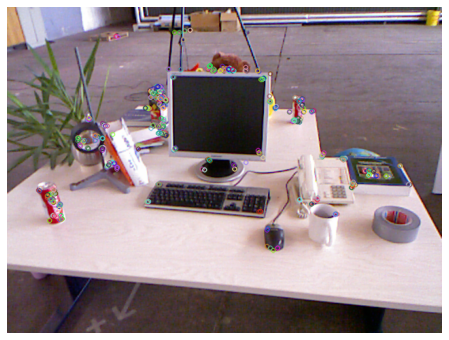

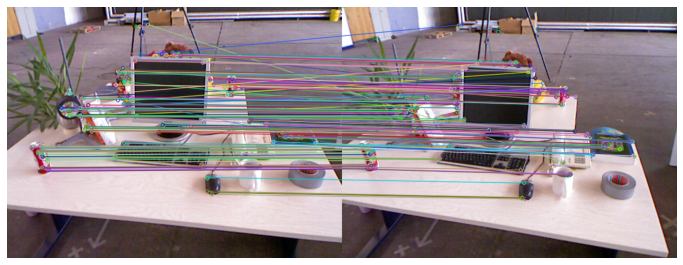

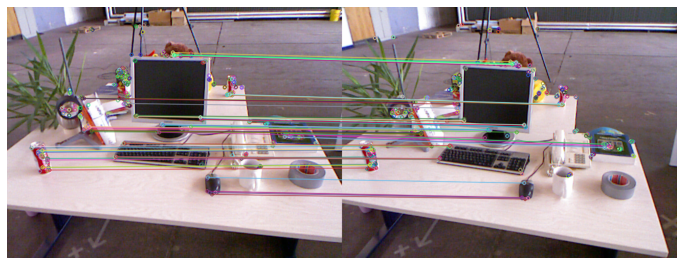

In [8]:
# feature_extraction.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import cv2
import matplotlib.pyplot as plt

if __name__ =="__main__":
    
    # 读取图像
    image_1 = cv2.imread("./chapter_07/1.png")
    image_2 = cv2.imread("./chapter_07/2.png")
    
    # 初始化
    orb = cv2.ORB_create(
        nfeatures=500,
        scaleFactor=1.2,
        nlevels=8,
        edgeThreshold=31,
        firstLevel=0,
        WTA_K=2,
        scoreType=cv2.ORB_HARRIS_SCORE,
        patchSize=31,
        fastThreshold=20
    )
    
    # 第一步：检测Oriented FAST角点位置
    # 第二步：根据角点位置计算BRIEF描述子
    keypoints_1, descriptors_1 = orb.detectAndCompute(image=image_1, mask=None)
    keypoints_2, descriptors_2 = orb.detectAndCompute(image=image_2, mask=None)
    
    output_1 = image_1.copy()
    cv2.drawKeypoints(
        image=image_1,
        keypoints=keypoints_1,
        outImage=output_1,
        flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT
        # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    cv2.imshow("ORB特征点", output_1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 第三步：对两幅图像中的BRIEF描述子（二进制）进行匹配，使用Hamming距离
    matcher = cv2.BFMatcher_create(
        normType=cv2.NORM_HAMMING, crossCheck=True
    )
    matches = matcher.match(
        queryDescriptors=descriptors_1,
        trainDescriptors=descriptors_2
    )
    
    # 第四步：匹配点对筛选
    min_dist = 10000
    max_dist = 0
    # 找出所有匹配之间的最小距离和最大距离，即最相似的匹配点之间的距离和最不相似的匹配点之间的距离
    for match in matches:
        dist = match.distance
        if dist < min_dist:
            min_dist = dist
        if dist > max_dist:
            max_dist = dist
            
    print("-- max dist: %f" % max_dist)
    print("-- min dist: %f" % min_dist)
    
    # 当描述子之间的距离大于两倍的最小距离时，即认为匹配有误。
    # 但有时候最小距离会非常小，可以设置一个经验值作为下限。
    good_matches = []
    for match in matches:
        if match.distance <= max(2 * min_dist, 30):
            good_matches.append(match)
            
    # 第五步：绘制匹配结果
    image_match = cv2.drawMatches(
        img1=image_1, keypoints1 = keypoints_1,
        img2=image_2, keypoints2 = keypoints_2,
        matches1to2=matches,
        outImg=None
    )
    image_good_match = cv2.drawMatches(
        img1=image_1, keypoints1 = keypoints_1,
        img2=image_2, keypoints2 = keypoints_2,
        matches1to2=good_matches,
        outImg=None
    )
    
    cv2.imshow("所有匹配点对", image_match)
    cv2.imshow("优化后匹配点对", image_good_match)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(output_1, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    fig = plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(image_match, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    fig = plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(image_good_match, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    

## 7.3 2D-2D：对极几何

### 7.3.1 对极约束

若已知两帧图像间的一组匹配特征点，则根据这些匹配特征点间的对应关系，可以恢复两帧间相机运动。

<img src="./img/fig_7_7.png" width="350" />

考虑两帧图像$I_{1}$、$I_{2}$间相机的运动，相机从第一帧到第二帧的运动记为$\mathbf{R}, \mathbf{t}$，两帧相机坐标中心分别为$\mathbf{O}_{1}$、$\mathbf{O}_{2}$。假设$I_{1}$中的特征点$\mathbf{p}_{1}$与$I_{2}$中的特征点$\mathbf{p}_{2}$匹配，则$\mathbf{p}_{1}$、$\mathbf{p}_{2}$为*空间中同一点$\mathbf{P}$分别在两帧成像平面上的投影*，即射线$\overrightarrow{\mathbf{O}_{1}\mathbf{p}_{1}}$、$\overrightarrow{\mathbf{O}_{2}\mathbf{p}_{2}}$相交于点$\mathbf{P}$。称点$\mathbf{O}_{1}$、$\mathbf{O}_{2}$、$\mathbf{P}$所确定的平面为极平面（epipolar plane）；线段$\overline{\mathbf{O}_{1}\mathbf{O}_{2}}$为基线（baseline）；$\overline{\mathbf{O}_{1}\mathbf{O}_{2}}$与像平面$I_{1}$、$I_{2}$的交点$\mathbf{e}_{1}$、$\mathbf{e}_{2}$为极点（epipole）；极平面与像平面$I_{1}$、$I_{2}$的交线为极线（epipolar line）。

射线$\overrightarrow{\mathbf{O}_{1}\mathbf{p}_{1}}$表示图像$I_{1}$中点（像素）$\mathbf{p}_{1}$在空间中对应点$\mathbf{P}$的可能坐标集合；射线（极线）$\overrightarrow{\mathbf{e}_{w}\mathbf{p}_{2}}$表示点$\mathbf{P}$在$I_{2}$中可能的投影坐标集合，即射线$\overrightarrow{\mathbf{O}_{1}\mathbf{p}_{1}}$在$I_{2}$上的投影。因此，通过特征点匹配，可以找到$I_{1}$中的特征点$\mathbf{p}_{1}$在$I_{2}$中的坐标$\mathbf{p}_{2}$，进而推断$\mathbf{P}$的空间坐标以及相机运动。若没有特征匹配，则需要通过在极线上搜索以确定$\mathbf{p}_{2}$的坐标。

**对极约束**

在第一帧相机坐标系下，点$\mathbf{P}$的空间坐标记为：

$$\mathbf{P} = [X, Y, Z]^\text{T}$$

根据针孔相机模型，可知像素点$\mathbf{p}_{1}$、$\mathbf{p}_{2}$的像素坐标满足：

$$s_{1} \mathbf{p}_{1} = \mathbf{K} \mathbf{P}, \quad s_{2} \mathbf{p}_{2} = \mathbf{K} (\mathbf{R} \mathbf{P} + \mathbf{t}) \tag{7-1}$$

其中，$\mathbf{K}$表示相机内参矩阵，$\mathbf{R}$、$\mathbf{t}$表示两帧相机坐标系间的相机运动。若采用齐次坐标，可将上式写成乘以非零常数成立的等式（up to a scale）：

$$\mathbf{p}_{1} = \mathbf{K} \mathbf{P}, \quad \mathbf{p}_{2} = \mathbf{K} (\mathbf{R} \mathbf{P} + \mathbf{t}) \tag{7-2}$$

令$\mathbf{x}_{1}$、$\mathbf{x}_{2}$分别表示$\mathbf{p}_{1}$、$\mathbf{p}_{2}$在两帧相机归一化平面下的坐标，可知：

$$\mathbf{x}_{1} = \mathbf{K}^{-1} \mathbf{p}_{1}, \quad \mathbf{x}_{2} = \mathbf{K}^{-1} \mathbf{p}_{2} \tag{7-3}$$

且满足：

$$\mathbf{x}_{2} = \mathbf{R} \mathbf{x}_{1} + \mathbf{t} \tag{7-4}$$

方程（7-4）两端同时左乘$\mathbf{t}^{\wedge}$（相当于与$\mathbf{t}$做外积），并左乘$\mathbf{x}_{2}^{\text{T}}$：

$$\mathbf{x}_{2}^{\text{T}} \mathbf{t}^{\wedge} \mathbf{x}_{2} = \mathbf{x}_{2}^{\text{T}} \mathbf{t}^{\wedge} \mathbf{R} \mathbf{x}_{1} + \mathbf{t} \tag{7-6}$$



